LOADING THE DATASET

In [1]:
from keras.datasets import mnist
import numpy as np

(trainImages, _), (testImages, _) = mnist.load_data()

trainImages, testImages = trainImages / 255.0, testImages / 255.0

#print("Training dimensions:", trainImages.shape)
#print("Test dimensions:", testImages.shape)

flattenedTrainImages = trainImages.reshape((trainImages.shape[0], -1))
flattenedTestImages = testImages.reshape((testImages.shape[0], -1))

print("Flattened training dimensions:", flattenedTrainImages.shape)
print("Flattened test dimensions:", flattenedTestImages.shape)

np.random.seed(42)      #To ensure that same images are used across pca and ppca. Change seed value for different images
selectedImages = np.random.choice(len(testImages), size = 5, replace=False)

Flattened training dimensions: (60000, 784)
Flattened test dimensions: (10000, 784)


PCA IMPLEMENTATION

MSE for latent dimension 2 is: 0.05566949193442309


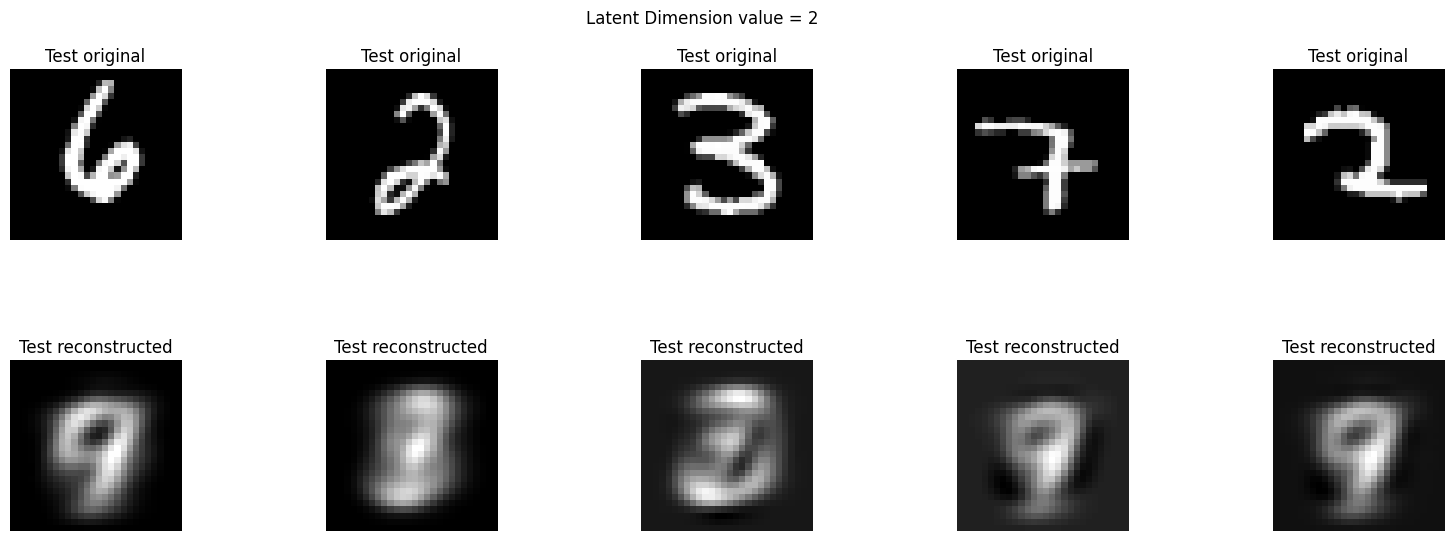

MSE for latent dimension 4 is: 0.04790346506558457


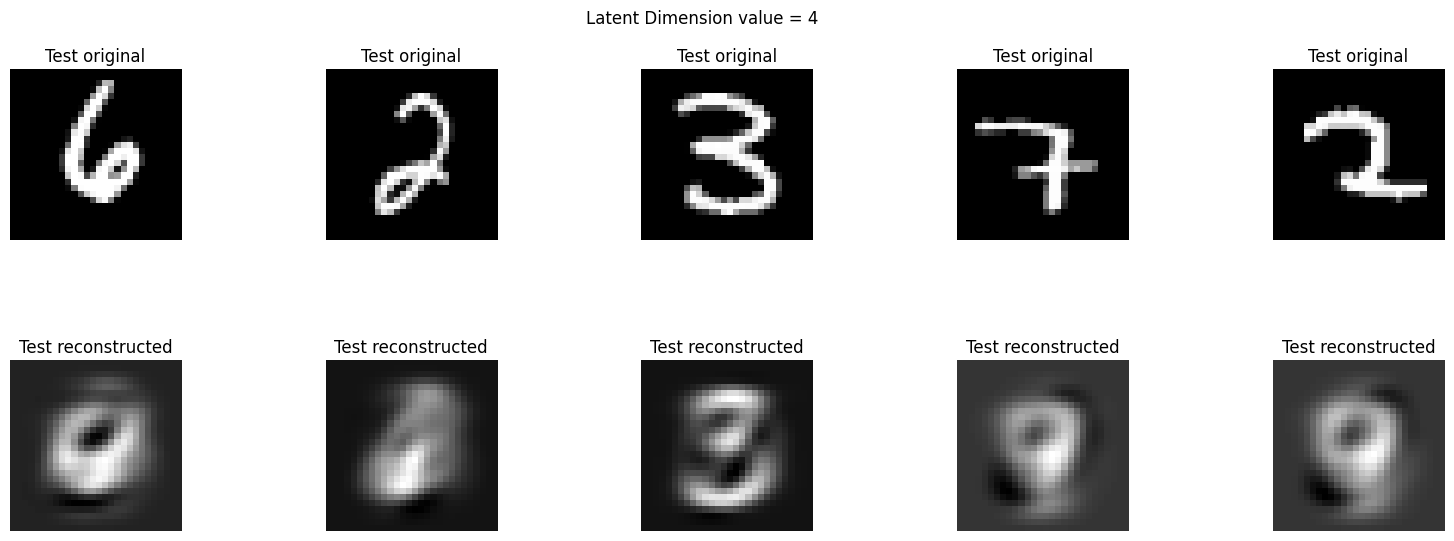

MSE for latent dimension 8 is: 0.037440933919030965


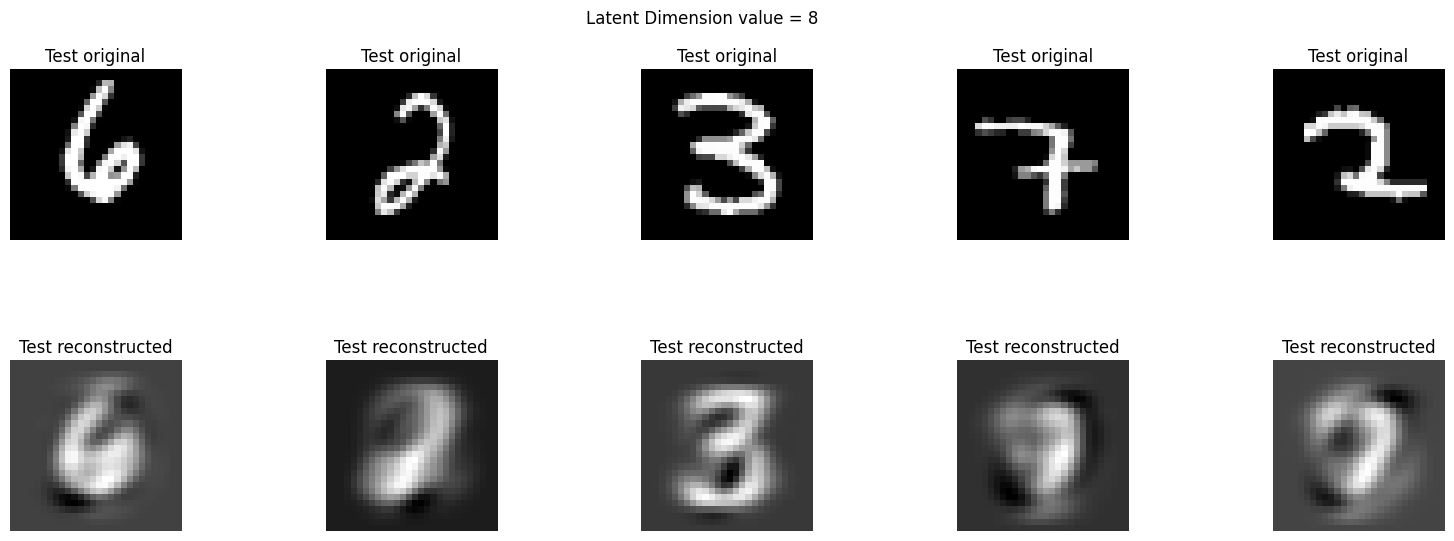

MSE for latent dimension 16 is: 0.02686019078827122


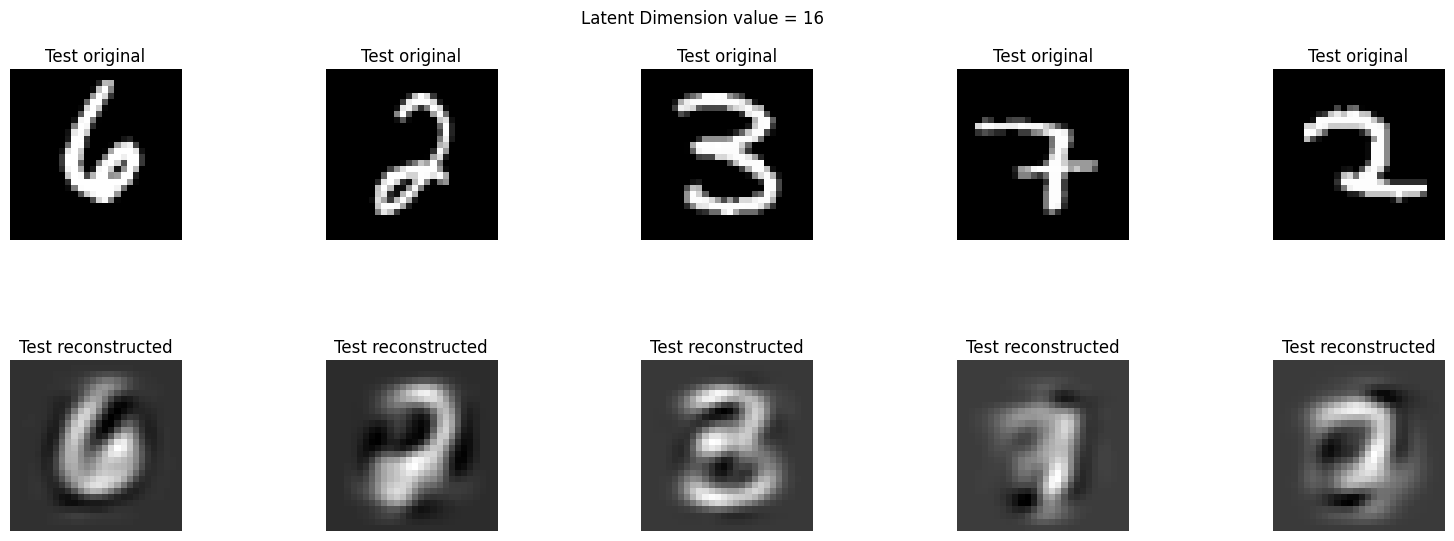

MSE for latent dimension 32 is: 0.016829987691859553


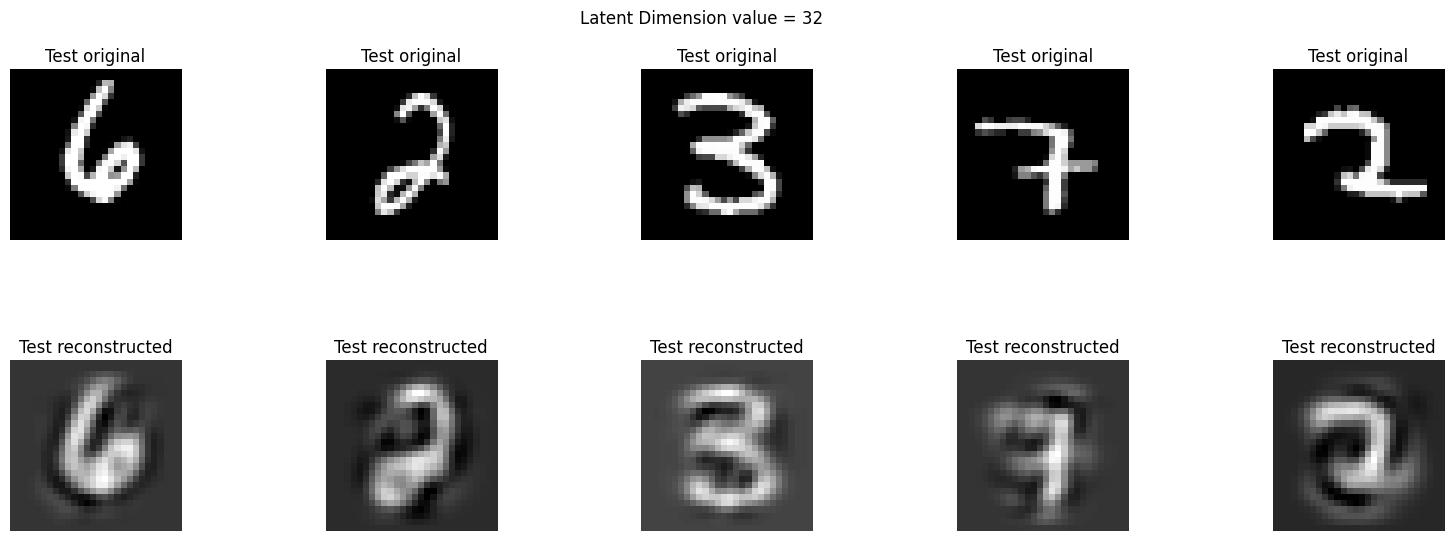

MSE for latent dimension 64 is: 0.009047770446754689


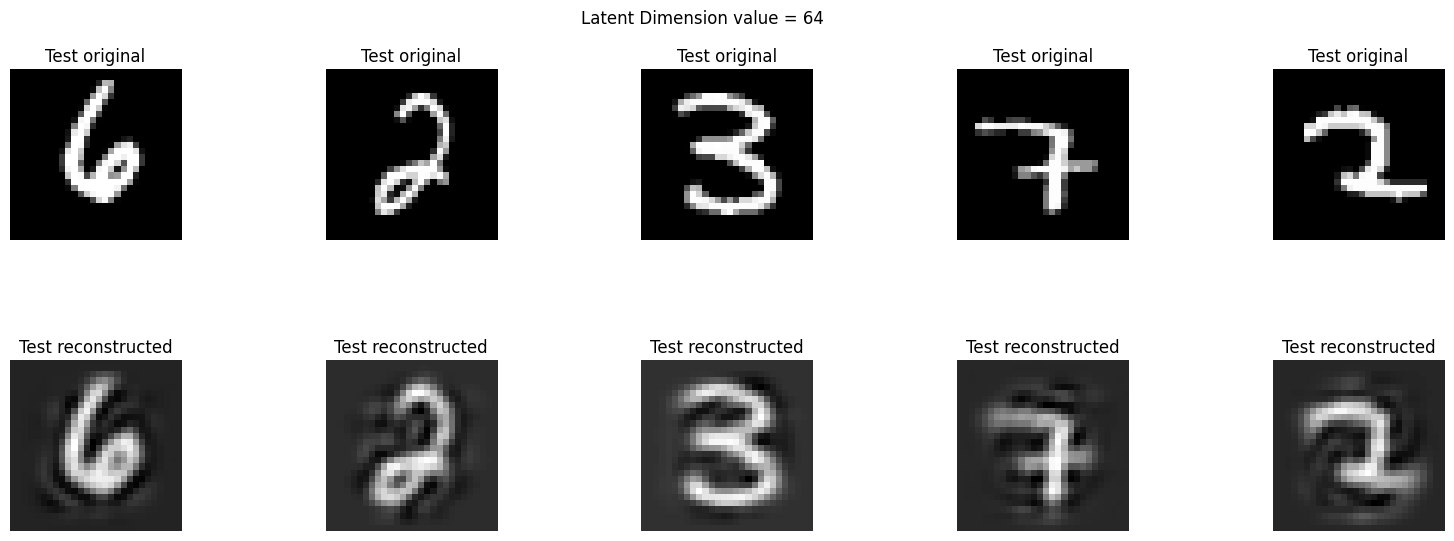

In [2]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

latentDimensions = [2, 4, 8, 16, 32, 64] 

def pcaFn(latentDimensionValue, flattenedTestImages):
    pca = PCA(n_components=latentDimensionValue)
    pca.fit(flattenedTrainImages)

    transformedImages = pca.inverse_transform(pca.transform(flattenedTestImages))
    transformedImages = transformedImages.reshape((-1, 28 * 28))    #Converting into 2d array

    return transformedImages

def pcaMSE(originalImages, reconstructedImages):
    return np.mean((originalImages - reconstructedImages)**2)

for latentDimensionValue in latentDimensions:

    reconstructedImages = pcaFn(latentDimensionValue, flattenedTestImages)
    mseVal = pcaMSE(flattenedTestImages,reconstructedImages)

    print("MSE for latent dimension {} is: {}".format(latentDimensionValue,mseVal))

    plt.figure(figsize=(20,6))
    plt.suptitle(f"Latent Dimension value = {latentDimensionValue}")

    for i, idx in enumerate(selectedImages):
        plt.subplot(2, 5, i + 1)
        plt.imshow(testImages[idx], cmap='gray')
        plt.title(f"Test original")
        plt.axis('off') #Removes x and y axis labels

        plt.subplot(2, 5, i + 6)
        plt.imshow(reconstructedImages[idx].reshape(28,28), cmap='gray')    #reshaping the 1d array back to 2d for accessing
        plt.title(f"Test reconstructed")
        plt.axis('off')

    plt.subplots_adjust(hspace=0.7, wspace=0.1)
    plt.show()



PROBABILISTIC PCA IMPLEMENTATION

MSE val for latent dimension 2 is 0.10603286571981226


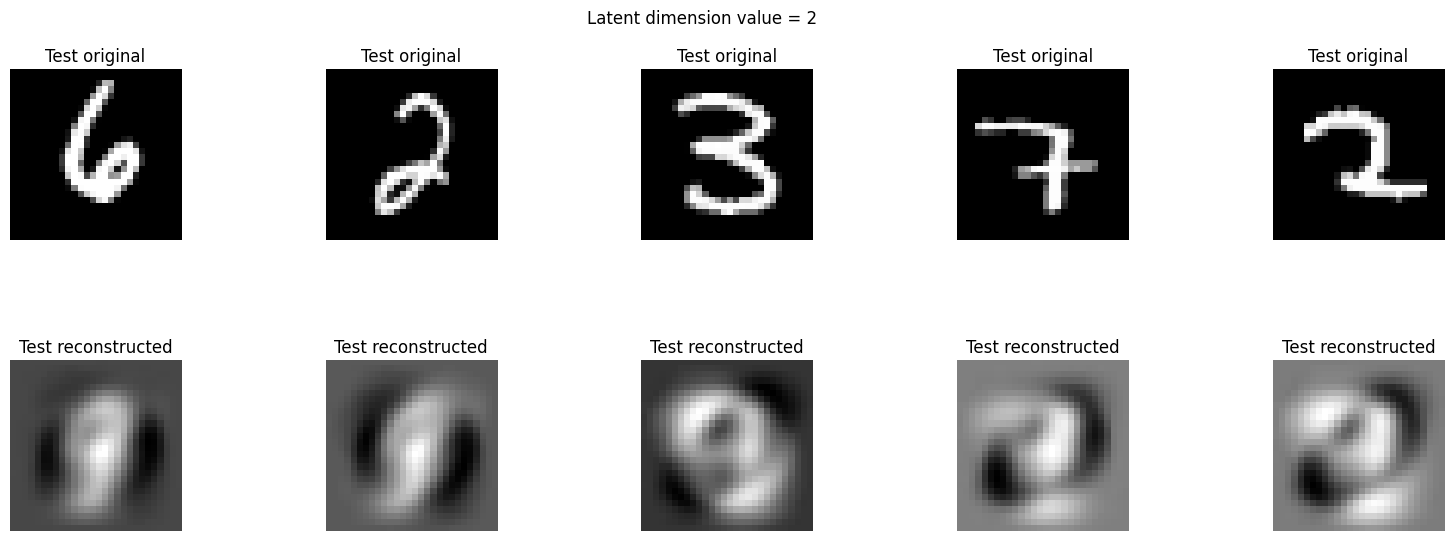

MSE val for latent dimension 4 is 0.12826227946705962


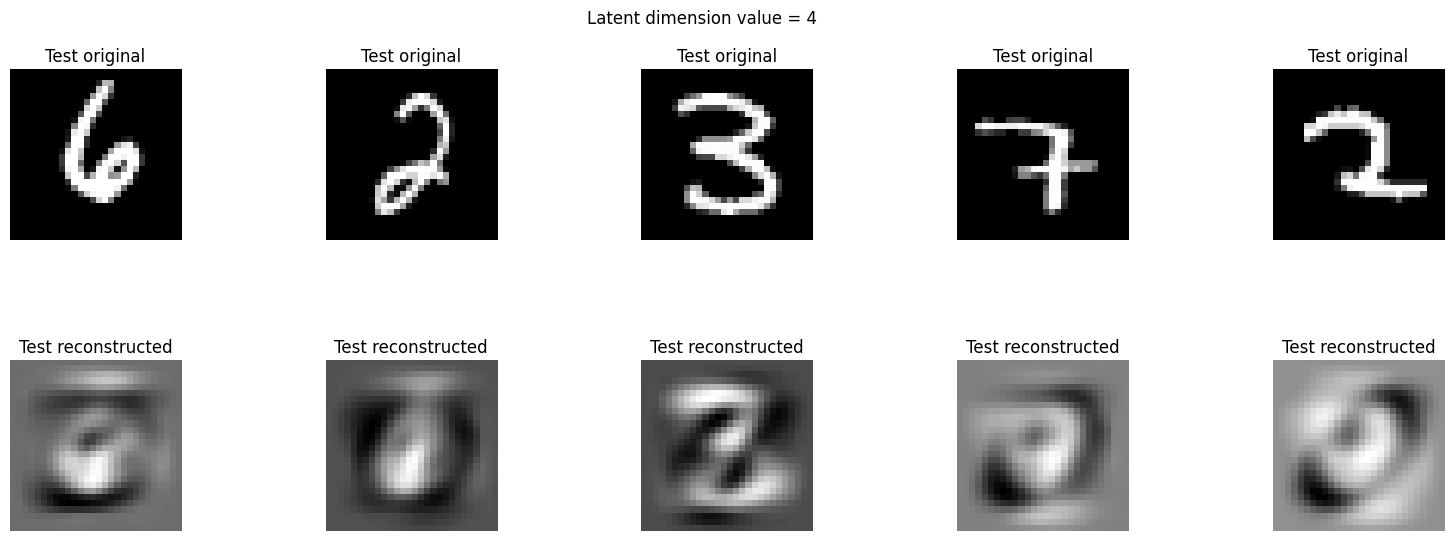

MSE val for latent dimension 8 is 0.17135643600887077


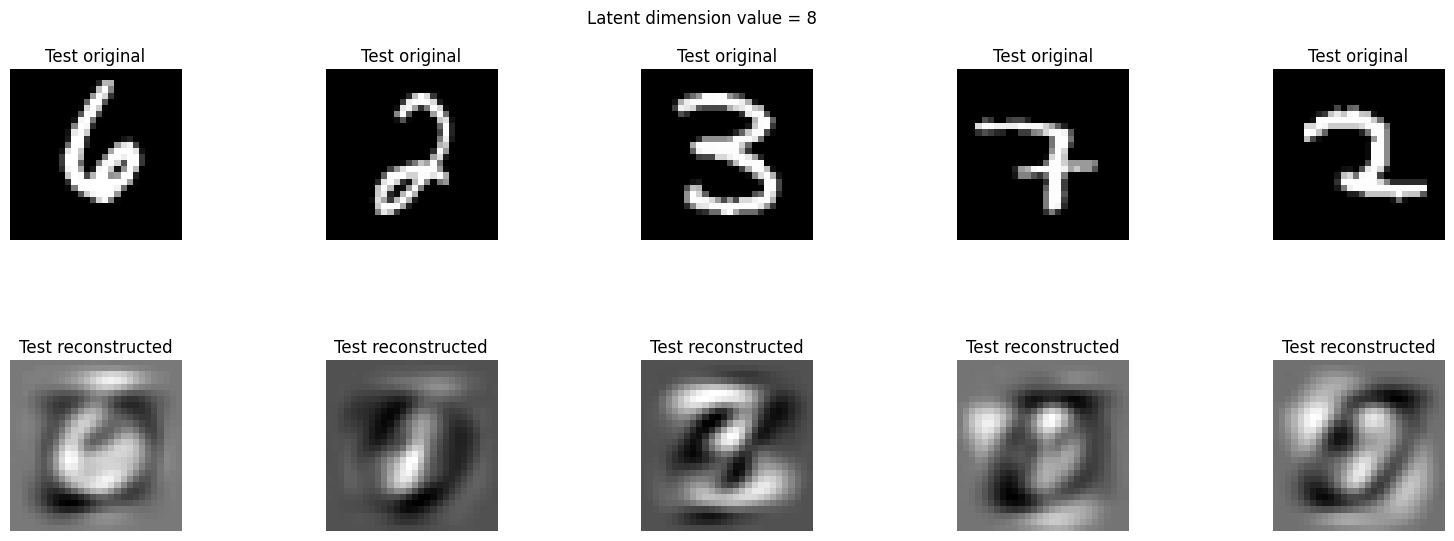

MSE val for latent dimension 16 is 0.22242467271268518


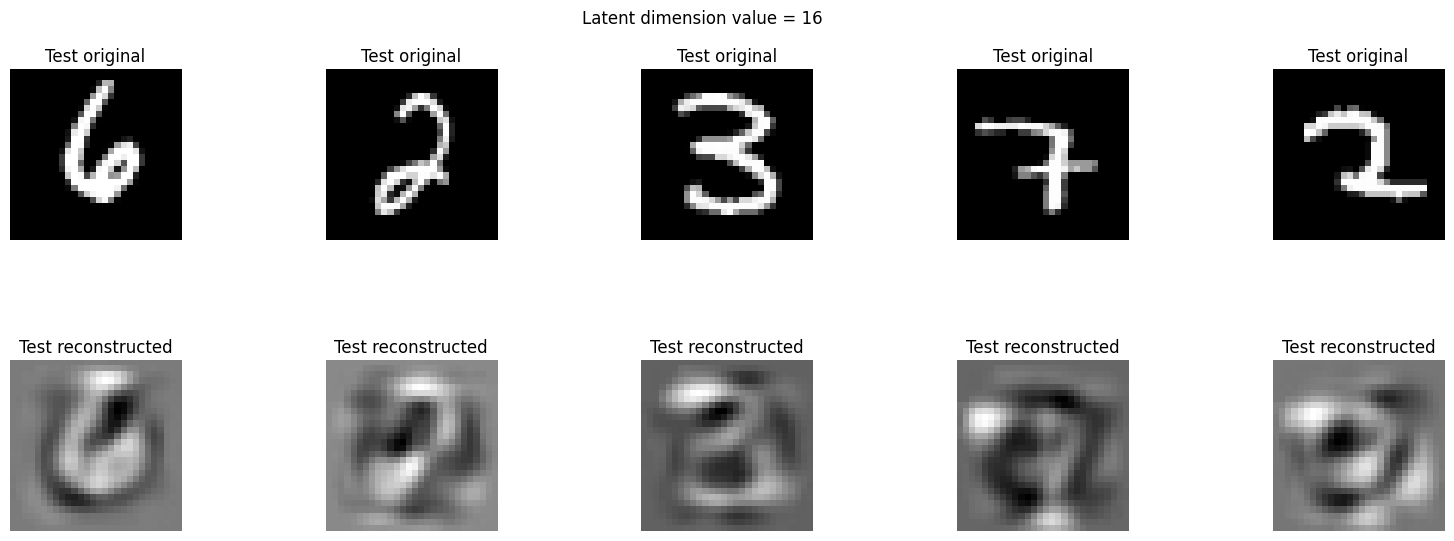

MSE val for latent dimension 32 is 0.28454290601727755


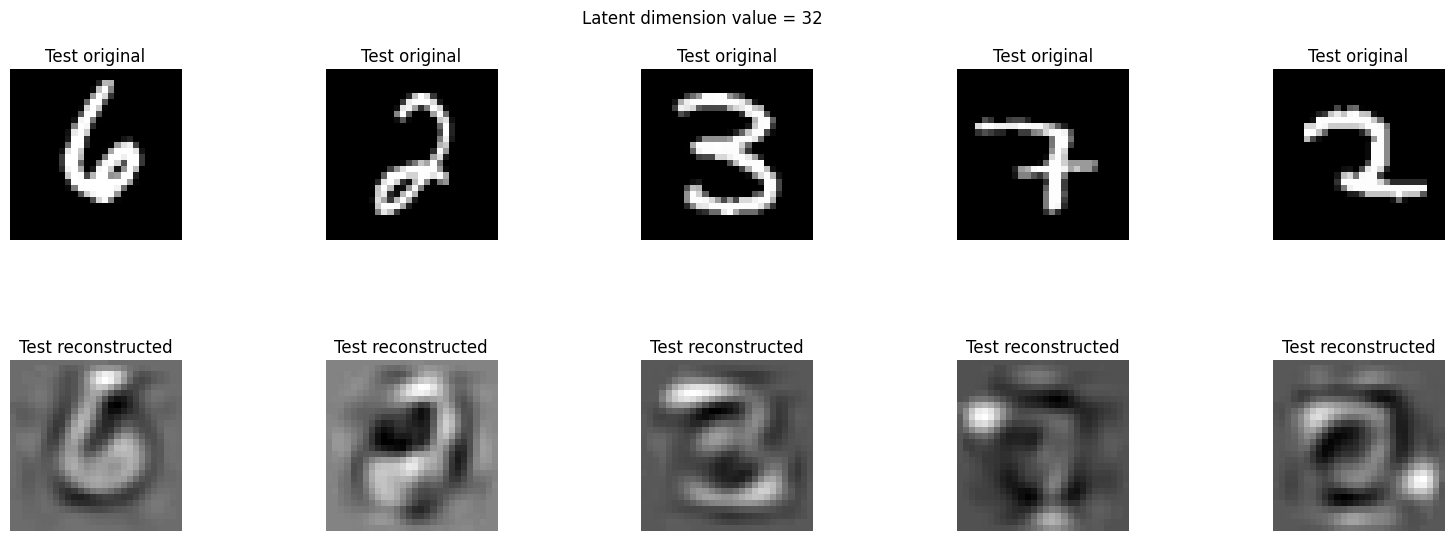

MSE val for latent dimension 64 is 0.36486861253223507


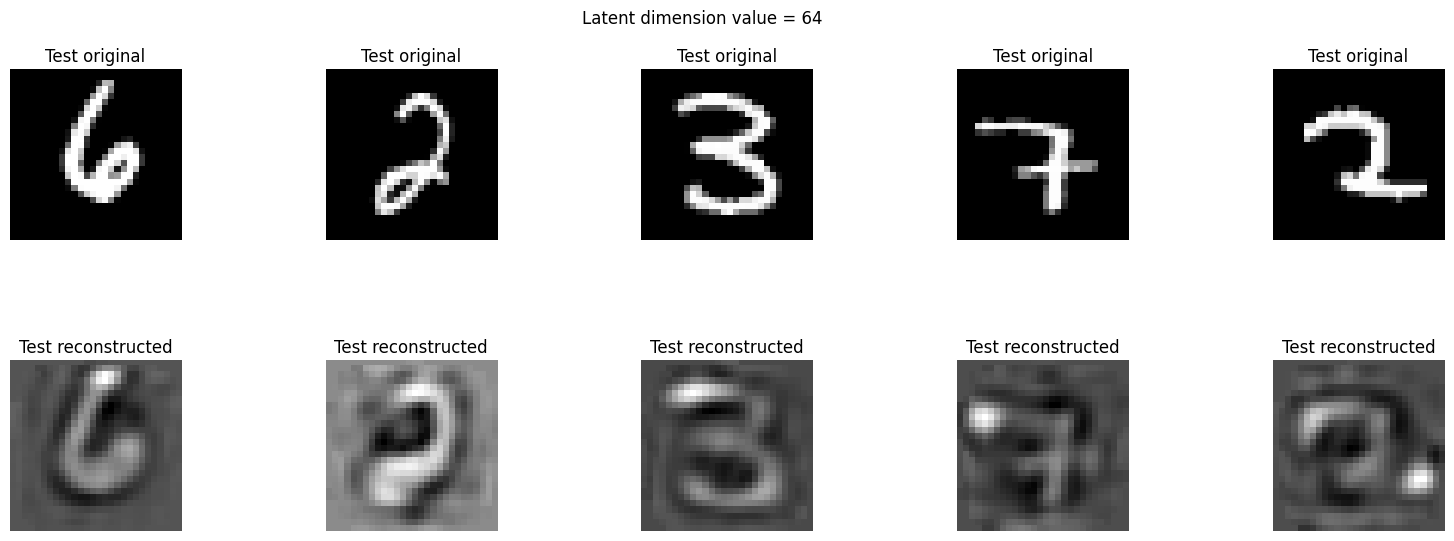

In [3]:
import numpy as np
import matplotlib.pyplot as plt

latentDimensions = [2, 4, 8, 16, 32, 64]

def normalization(flattenedTrainImages):
    mean = np.mean(flattenedTrainImages, axis = 0)
    standardDev = np.std(flattenedTrainImages, axis = 0)

    #Handle 0 variance here, else NaN values are produced
    zeroVarianceIndices = np.where(standardDev == 0)[0]
    standardDev[zeroVarianceIndices] = 1e-5

    normalizedImages = (flattenedTrainImages - mean) / standardDev
    return normalizedImages, mean, standardDev

def probabilisticPCA(normalizedTrainImages, latentDimensionValue):
    numSamples = normalizedTrainImages.shape[0]
    covarianceMatrix = (1/numSamples) * normalizedTrainImages.T @ normalizedTrainImages

    #nan_indices = np.where(np.isnan(covarianceMatrix))
    #print("Indices with NaN in Covariance Matrix:", nan_indices)


    #print("Any NaN in Covariance Matrix:", np.any(np.isnan(covarianceMatrix)))       
    
    eigenValues, eigenVectors = np.linalg.eigh(covarianceMatrix)


    Um = eigenVectors[:, -latentDimensionValue:]    
    Lm = np.diag(eigenValues[-latentDimensionValue:])   #Diagonal matrix of eigenvalues

    I = np.identity(latentDimensionValue)
    sigmaSquare = np.mean(eigenValues[:-latentDimensionValue])
    R = I  # Since its arbitrary, we take identity matrix
    
    weights = Um @ np.sqrt(Lm - sigmaSquare * I) @ R

    return weights


def imageReconstruction(normalizedImages, weights, mean):
    #Z, residuals, _, _ = np.linalg.lstsq(weights.T @ weights + 1e-5 * np.eye(weights.shape[1]), weights.T @ (normalizedImages - mean).T, rcond=None) 
    #print("Weights.T @ Weights:", weights.T @ weights)
    #print("Weights.T @ (normalizedImages - mean).T:", weights.T @ (normalizedImages - mean).T)

    Z = np.linalg.solve((weights.T @ weights), (weights.T) @ (normalizedImages - mean).T) 
    #X = WZ + u
    return (weights @ Z).T + mean

def probabilisticPcaMSE(originalImages, reconstructedImages):
    return np.mean((originalImages - reconstructedImages)**2)



normalizedTrainImages, mean, standardDev = normalization(flattenedTrainImages)

for latentDimensionValue in latentDimensions:

    normalizedTestImages = (flattenedTestImages - mean) / standardDev
    weights = probabilisticPCA(normalizedTrainImages, latentDimensionValue)
    reconstructedImages = imageReconstruction(normalizedTestImages, weights, mean)
    
    mseVal = probabilisticPcaMSE(flattenedTestImages, reconstructedImages) 
    print("MSE val for latent dimension {} is {}".format(latentDimensionValue,mseVal))

    plt.figure(figsize=(20,6))
    plt.suptitle(f"Latent dimension value = {latentDimensionValue}")
    #print(reconstructedImages.shape)
    
    for i, idx in enumerate(selectedImages):
        plt.subplot(2, 5, i + 1)
        plt.imshow(testImages[idx], cmap='gray')
        plt.title(f"Test original")
        plt.axis('off') #Removes x and y axis labels

        plt.subplot(2, 5, i + 6)
        plt.imshow(reconstructedImages[idx].reshape(28,28), cmap='gray')    #reshaping the 1d array back to 2d for accessing
        plt.title(f"Test reconstructed")
        plt.axis('off')

    plt.subplots_adjust(hspace=0.7, wspace=0.1)
    plt.show()
    
    